<a href="https://colab.research.google.com/github/ashishkathane599/E-Waste-Generation-classification-/blob/main/E_Waste_Generation_Classificaton.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

import requrired libraries

In [3]:
import tensorflow as tf
from tensorflow.keras import layers,models,optimizers,callbacks
from tensorflow.keras.models import Sequential,load_model
from tensorflow.keras.applications import EfficientNetV2B0
from tensorflow.keras.applications.efficientnet import preprocess_input
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix,classification_report
import gradio as gr
from PIL import Image

In [4]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
testpath = '/content/drive/MyDrive/E-Waste classification dataset/modified-dataset/test'
trainpath= '/content/drive/MyDrive/E-Waste classification dataset/modified-dataset/train'
validpath= '/content/drive/MyDrive/E-Waste classification dataset/modified-dataset/val'

split data into training ,validation and testing set

usnig :-  image_dataset_from_directory



In [6]:
datatrain = tf.keras.utils.image_dataset_from_directory(trainpath,shuffle=True,image_size =(128,128),batch_size = 32 , validation_split = False )

Found 2401 files belonging to 10 classes.


In [7]:
datatest = tf.keras.utils.image_dataset_from_directory(testpath,shuffle=True ,image_size=(128,128),batch_size = 32 , validation_split=False)

Found 300 files belonging to 10 classes.


In [8]:
datavalid = tf.keras.utils.image_dataset_from_directory(validpath,shuffle=True,image_size=(128,128),batch_size=32,validation_split=False)   # validation_split is use to split a % data for validation and other for train data

Found 300 files belonging to 10 classes.


In [9]:
print(len(datatrain.class_names))
class_name =datatrain.class_names   # from datasets the classes names
print(class_name)
print(datavalid.class_names)

10
['Battery', 'Keyboard', 'Microwave', 'Mobile', 'Mouse', 'PCB', 'Player', 'Printer', 'Television', 'Washing Machine']
['Battery', 'Keyboard', 'Microwave', 'Mobile', 'Mouse', 'PCB', 'Player', 'Printer', 'Television', 'Washing Machine']


Visualize sample images from each classs

In [10]:
plt.figure(figsize=(10,10))

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

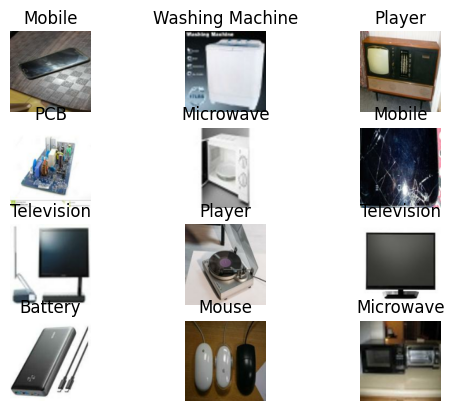

In [11]:
for images,labels in datatrain.take(1) : # dattrain tak 1 take a first batch of 32 images
   for i in range(12) :
      ax = plt.subplot(4,3,i+1)

      plt.imshow(images[i].numpy().astype("uint8"))
      plt.title(class_name[labels[i]])
      plt.axis("off")

In [12]:
def plot_class_distribution(dataset,title="Class Distribution") :
    class_counts  ={ }
    for images,labels in dataset :
        for labels in labels.numpy() :
          class_name = dataset.class_names[labels] # corrected to use the correct class name based on the label
          class_counts[class_name] = class_counts.get(class_name,0)+1
    class_names = list(class_counts.keys())  # List of class names
    counts = list(class_counts.values())     # Corresponding counts for each class
    # Create the bar plot
    plt.figure(figsize=(10, 6))  # Set the figure size
    plt.bar(class_names, counts, color='skyblue')  # Draw bars with class counts
    plt.xlabel("Class")  # X-axis label
    plt.ylabel("Number of Items")  # Y-axis label
    plt.title(title)  # Plot title
    plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
    plt.tight_layout()  # Adjust layout to prevent clipping
    plt.show()  # Display the ploting counts for each class


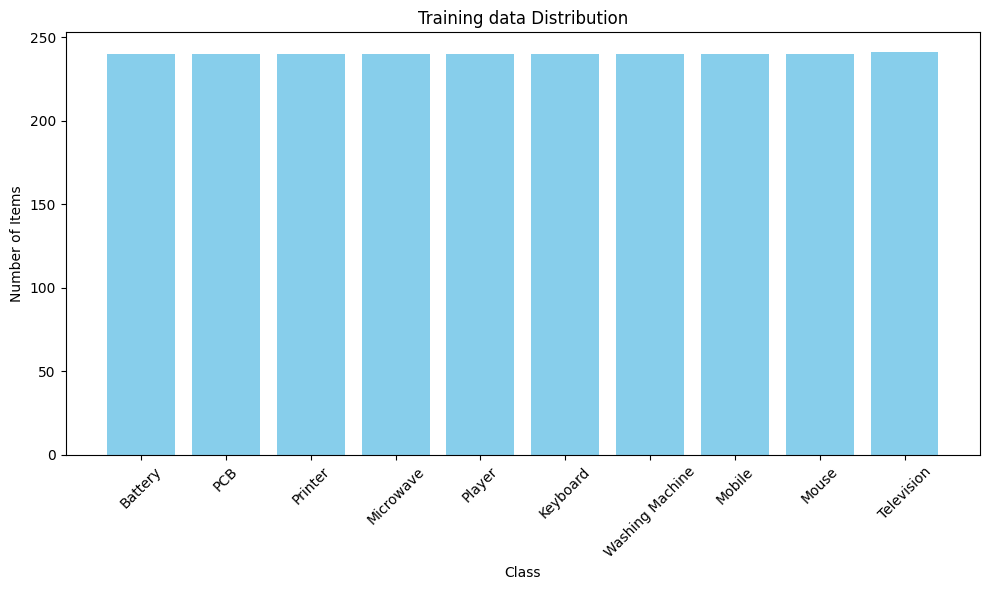

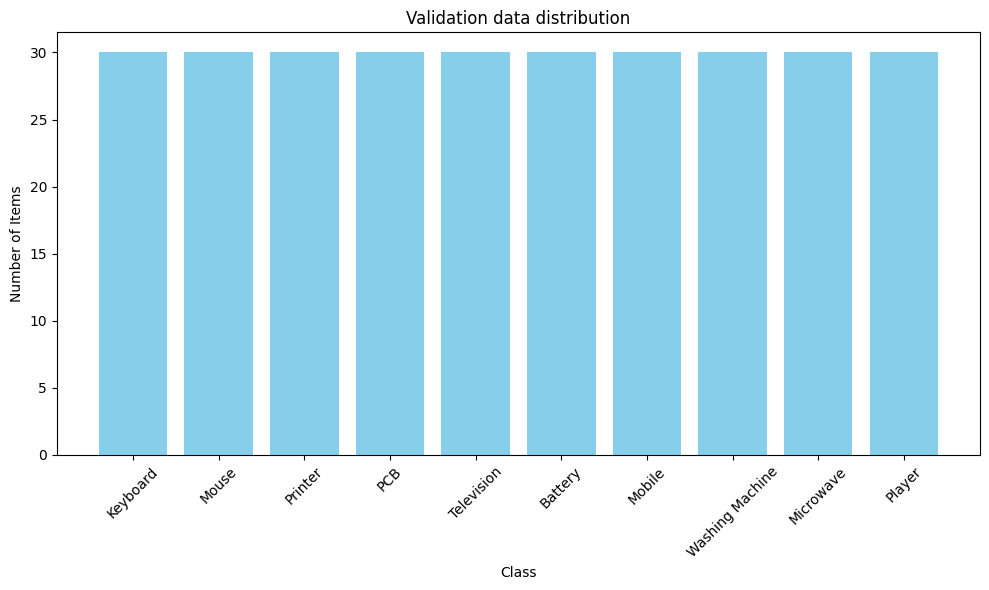

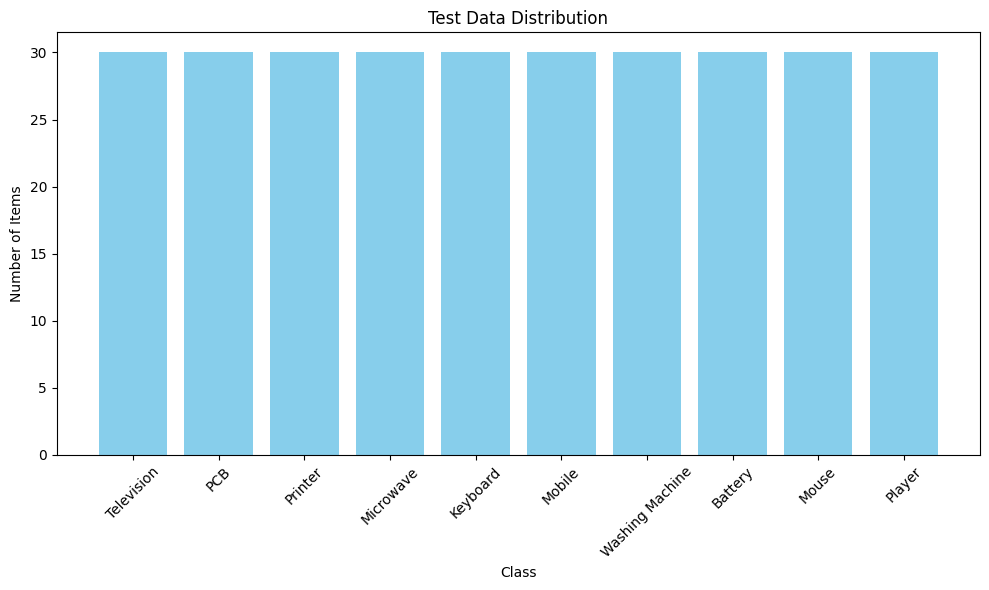

In [13]:
plot_class_distribution(datatrain,"Training data Distribution")
plot_class_distribution(datavalid,"Validation data distribution")
plot_class_distribution(datatest,"Test Data Distribution")

Data processing
  

*   Resize and rescale images
*   apply data augmentation (eg. RandomFlip , RandomRotation,RandomZoom)to improve genralization

*   Normalize images (using preprocess_input if using pre-trained models like EfficienNet)


In [14]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal") ,
    tf.keras.layers.RandomRotation(0.1) ,
    tf.keras.layers.RandomZoom(0.1) ,
])

Model selection  


*   Choose a base model Custom CNN or Tranfer Learning (eg. EfficientNetv2b0)
*  Decide wheterh ro use pre-trained weights 9eg. ImageNet)
*  Define whether layers should be trainable or frozen during intital training



In [15]:
base_model = tf.keras.applications.EfficientNetB0(
    input_shape=(128,128,3),
    include_top = False ,
    weights = 'imagenet'
)

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model Training
* Buld the model architecture using sequntial or Functional API
*Compile the model with loss function (sparse_categorical_crossentropy),optimizer eg. adam) and evaluatio matrics (accuracy) .

5. Model Tuning and Optimization
Tune hyperparameters: learning rate, batch size, number of layers, dropout rate.
Use callbacks: EarlyStopping,
Optionally perform fine-tuning on pre-trained models by unfreezing some layers.
Model Architecture and Layer Utilities
Sequential: A simple way to build models by stacking layers one after the other in a linear fashion.

RandomFlip: A data augmentation layer that flips input images horizontally or vertically at random, helping the model generalize better.

RandomRotation: Randomly rotates images by a specified angle range during training to make the model invariant to orientation.

RandomZoom: Applies random zoom-in or zoom-out to training images, helping the model recognize objects at various scales.

Dropout: A regularization method that randomly "drops" (sets to zero) a fraction of input units during training to prevent overfitting.

GlobalAveragePooling2D: Reduces each feature map to a single number by taking the average, reducing model parameters and helping prevent overfitting.

Dense: A fully connected neural network layer used to learn complex features and typically found at the end of the model for classification.

Input: Specifies the input shape and data type for the model; acts as the starting point of the model architecture.

EfficientNetV2B0: A pre-trained convolutional neural network from the EfficientNetV2 family, known for being lightweight and high-performing, commonly used for transfer learning.

In [16]:
model = tf.keras.Sequential([
       tf.keras.layers.Input(shape=(128,128,3)) ,
       data_augmentation,
       base_model,
       tf.keras.layers.GlobalAveragePooling2D() ,
       tf.keras.layers.Dropout(0.2) ,
       tf.keras.layers.Dense(10,activation='softmax')
])
model.compile(optimizers.Adam(learning_rate=0.0001),loss = tf.keras.losses.SparseCategoricalCrossentropy(),metrics =['Accuracy'])

callbacks
* EarlyStopping : To stop trainning when validation performance stops improving

In [17]:
# Define an EarlyStopping callback to stop training when validation loss stops improving
early = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',           # Metric to monitor (validation loss here)
    patience=3,                   # Number of epochs to wait after last improvement before stopping
    restore_best_weights=True     # After stopping, restore the model weights from the epoch with the best val_loss
)

In [18]:
epochs = 15

# train  the model on the training dataset 'datatrain'
history =  model.fit(datatrain,                 # Training  data generator or dataset
                     validation_data=datavalid,  # validation data generator or dataset
                     epochs = epochs ,     # Number of training epochs
                     batch_size=100 ,      # Number of  samples per gradient update
                     callbacks =[early]   # List of callbacks to apply during training
                     )

Epoch 1/15
76/76 ━━━━━━━━━━━━━━━━━━━━ 289s 3s/step - Accuracy: 0.2676 - loss: 2.1353 - val_Accuracy: 0.8067 - val_loss: 1.0287
Epoch 2/15
76/76 ━━━━━━━━━━━━━━━━━━━━ 264s 3s/step - Accuracy: 0.7727 - loss: 0.9148 - val_Accuracy: 0.9233 - val_loss: 0.4112
Epoch 3/15
76/76 ━━━━━━━━━━━━━━━━━━━━ 256s 3s/step - Accuracy: 0.8593 - loss: 0.5013 - val_Accuracy: 0.9367 - val_loss: 0.2656
Epoch 4/15
76/76 ━━━━━━━━━━━━━━━━━━━━ 254s 3s/step - Accuracy: 0.9067 - loss: 0.3342 - val_Accuracy: 0.9333 - val_loss: 0.2322
Epoch 5/15
76/76 ━━━━━━━━━━━━━━━━━━━━ 254s 3s/step - Accuracy: 0.9248 - loss: 0.2522 - val_Accuracy: 0.9433 - val_loss: 0.2171
Epoch 6/15
76/76 ━━━━━━━━━━━━━━━━━━━━ 262s 3s/step - Accuracy: 0.9423 - loss: 0.1989 - val_Accuracy: 0.9400 - val_loss: 0.2158
Epoch 7/15
76/76 ━━━━━━━━━━━━━━━━━━━━ 262s 3s/step - Accuracy: 0.9617 - loss: 0.1534 - val_Accuracy: 0.9367 - val_loss: 0.2075
Epoch 8/15
76/76 ━━━━━━━━━━━━━━━━━━━━ 239s 3s/step - Accuracy: 0.9636 - loss: 0.1281 - val_Accuracy: 0.9533 - v

In [19]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 4, 4, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │        12,810 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,103,099 (46.17 MB)

 Trainable params: 4,020,358 (15.34 MB)

 Non-trainable params: 42,023 (164.16 KB)

 Optimizer params: 8,040,718 (30.67 MB)

In [20]:
base_model.summary()

Model: "efficientnetb0"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 128, 128,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 128, 128,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 128, 128,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 129, 129,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 64, 64,    │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 64, 64,    │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 64, 64,    │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 64, 64,    │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 64, 64,    │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 64, 64,    │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 64, 64,    │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 64, 64,    │        512 │ block1a_se_excit

 Total params: 4,049,571 (15.45 MB)

 Trainable params: 4,007,548 (15.29 MB)

 Non-trainable params: 42,023 (164.16 KB)

Model Performance Visualization: Accuracy & Loss Trends

In [21]:
### Plotting Training and Validation Accuracy and Loss Over Epochs

acc = history.history['Accuracy']           # Training accuracy
val_acc = history.history['val_Accuracy']   # Validation accuracy
loss = history.history['loss']              # Training loss
val_loss = history.history['val_loss']      # Validation loss

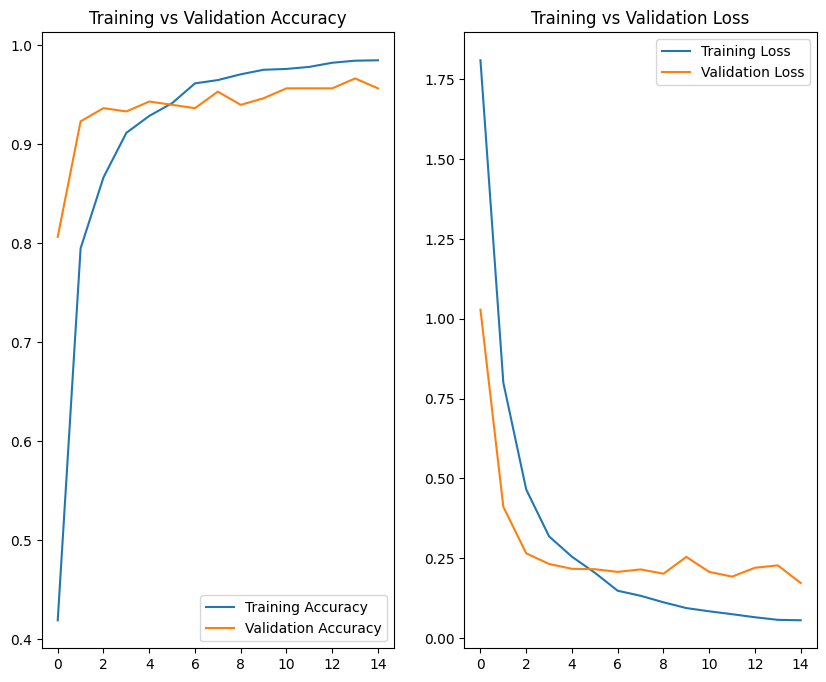

In [22]:
epochs_range = range(len(acc))              # X-axis range based on number of epochs

plt.figure(figsize=(10, 8))                 # Set overall figure size

plt.subplot(1, 2, 1)                        # 1 row, 2 columns, position 1
plt.plot(epochs_range, acc, label='Training Accuracy')       # Plot training accuracy
plt.plot(epochs_range, val_acc, label='Validation Accuracy') # Plot validation accuracy
plt.legend(loc='lower right')              # Show legend at lower right
plt.title('Training vs Validation Accuracy') # Set title for accuracy plot

plt.subplot(1, 2, 2)                        # 1 row, 2 columns, position 2
plt.plot(epochs_range, loss, label='Training Loss')          # Plot training loss
plt.plot(epochs_range, val_loss, label='Validation Loss')    # Plot validation loss
plt.legend(loc='upper right')              # Show legend at upper right
plt.title('Training vs Validation Loss')    # Set title for loss plot

plt.show()                                  # Display the plots

 Model Evaluation
* Plot training and validation accuracy/loss curves.
* Evaluate model performance on validation or test set.
* Use metrics like:
* Confusion Matrix
* Classification Report (Precision, Recall, F1-score)
* confusion_matrix, classification_report: To evaluate the model's classification performance.

In [23]:

loss, accuracy = model.evaluate(datatest)
print(f'Test accuracy is{accuracy:.4f}, Test loss is {loss:.4f}')

10/10 ━━━━━━━━━━━━━━━━━━━━ 8s 758ms/step - Accuracy: 0.9192 - loss: 0.2446
Test accuracy is0.9300, Test loss is 0.2223


In [24]:
### Evaluate Model Performance on Test Data using Confusion Matrix and Classification Report

# Extract true labels from all batches
y_true = np.concatenate([y.numpy() for x, y in datatest], axis=0)  # Ground truth labels

# Get predictions as probabilities and then predicted classes
y_pred_probs = model.predict(datatest)

# Class with highest probability
y_pred = np.argmax(y_pred_probs, axis=1)

# Print confusion matrix and classification report
print(confusion_matrix(y_true, y_pred))
print(classification_report(y_true, y_pred))

10/10 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step
[[2 2 6 0 4 3 5 1 2 5]
 [5 1 1 4 2 1 6 4 2 4]
 [5 1 3 3 4 5 2 2 2 3]
 [4 4 0 4 3 7 2 5 0 1]
 [2 1 5 3 4 1 3 4 4 3]
 [3 4 1 3 3 1 2 3 6 4]
 [3 3 6 4 2 3 2 2 3 2]
 [4 5 0 4 2 2 3 4 2 4]
 [4 5 6 1 4 2 3 1 2 2]
 [2 4 2 2 2 5 0 6 5 2]]
              precision    recall  f1-score   support

           0       0.06      0.07      0.06        30
           1       0.03      0.03      0.03        30
           2       0.10      0.10      0.10        30
           3       0.14      0.13      0.14        30
           4       0.13      0.13      0.13        30
           5       0.03      0.03      0.03        30
           6       0.07      0.07      0.07        30
           7       0.12      0.13      0.13        30
           8       0.07      0.07      0.07        30
           9       0.07      0.07      0.07        30

    accuracy                           0.08       300
   macro avg       0.08      0.08      0.08       300
weighted avg       0.08   

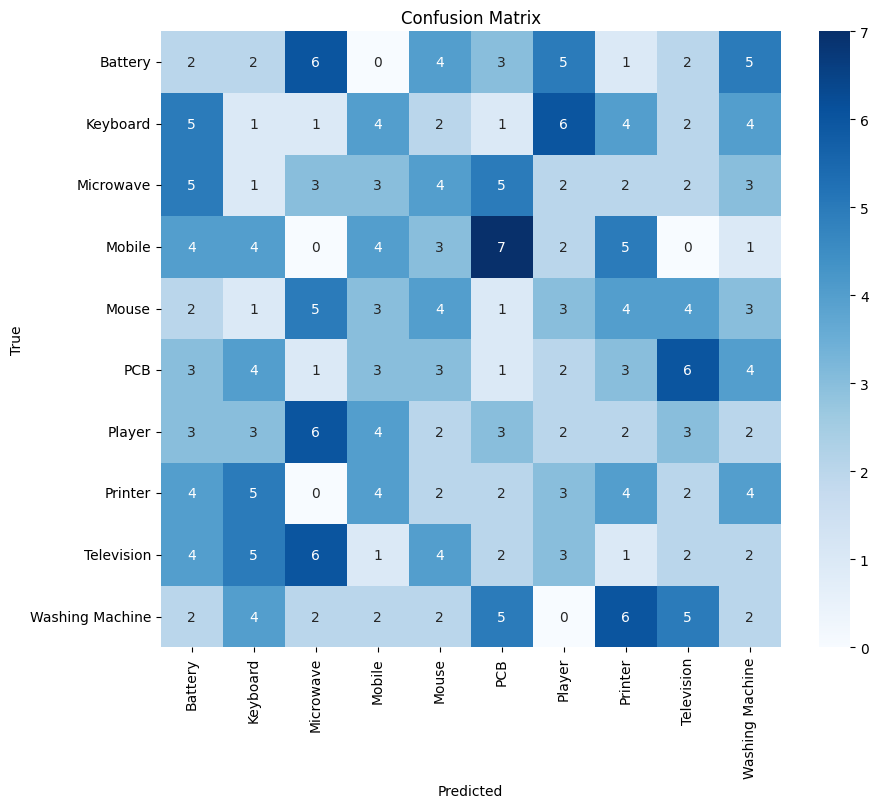

In [25]:
### Plot Confusion Matrix as Heatmap for Better Visualization

cm = confusion_matrix(y_true, y_pred)                                     # Compute confusion matrix
                                                     # Import seaborn for visualization

# Get class names from the test dataset
class_names = datatest.class_names

plt.figure(figsize=(10, 8))                                               # Set figure size
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=class_names,
            yticklabels=class_names,
            cmap='Blues')                                                 # Create heatmap with class labels

plt.xlabel('Predicted')                                                   # Label for x-axis
plt.ylabel('True')                                                        # Label for y-axis
plt.title('Confusion Matrix')                                             # Title for the plot
plt.show()

Final Testing and Save the Model
* Evaluate the final model on the unseen test dataset.

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


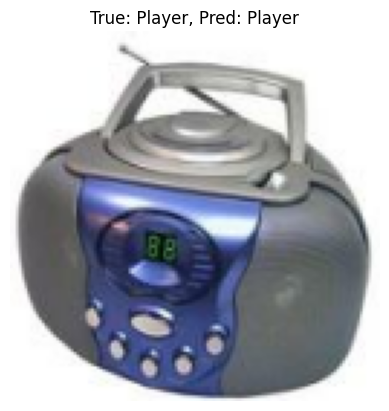

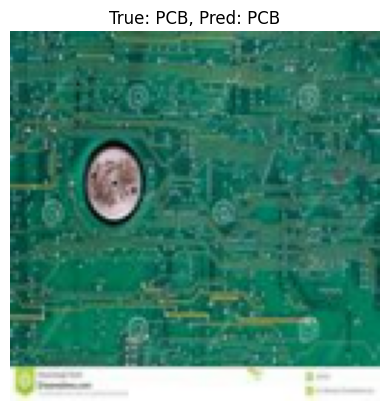

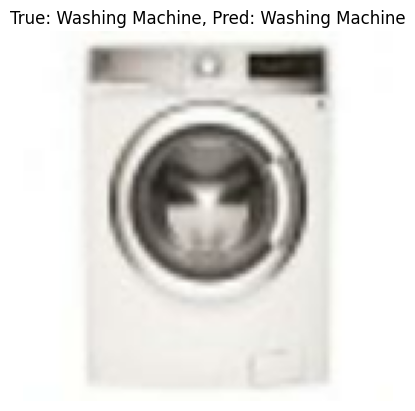

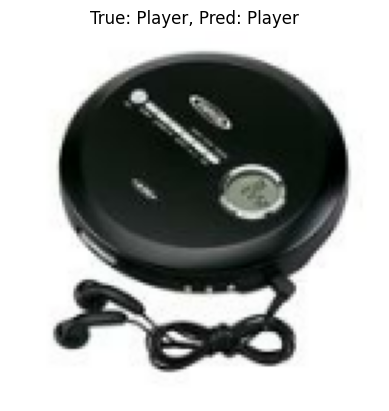

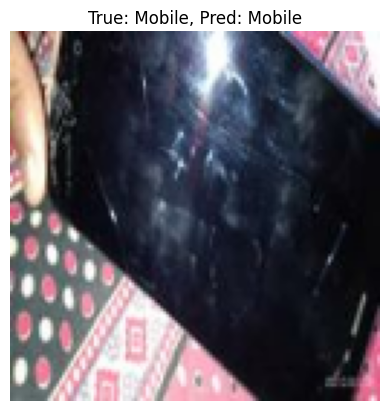

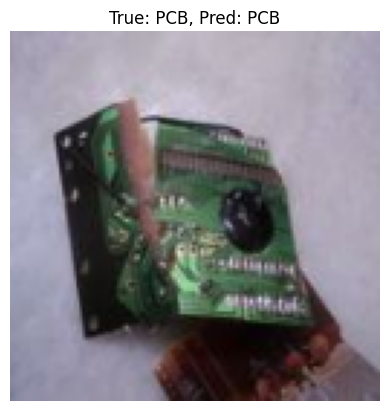

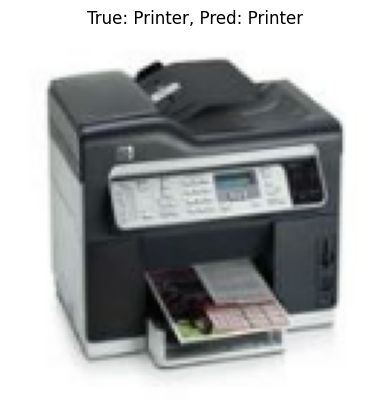

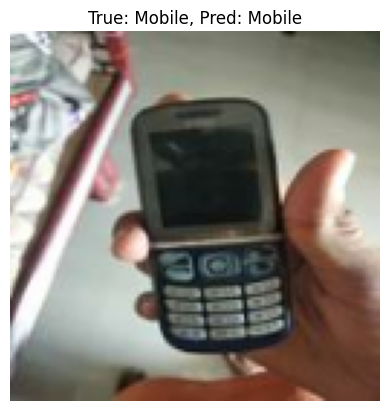

In [26]:
### Display Sample Predictions: True Labels vs Predicted Labels

class_names = datatest.class_names                                           # Get class names from test dataset

for images, labels in datatest.take(1):                                     # Take one batch from test data
    predictions = model.predict(images)                                     # Predict class probabilities
    pred_labels = tf.argmax(predictions, axis=1)                            # Get predicted class indices

    for i in range(8):                                                      # Display first 8 images from batch
        plt.imshow(images[i].numpy().astype("uint8"))                       # Convert tensor to image
        plt.title(f"True: {class_names[labels[i]]}, Pred: {class_names[pred_labels[i]]}")  # Title with labels
        plt.axis("off")                                                     # Hide axes
        plt.show()

In [33]:
# Save model in Keras format with architecture, weights, and training configuration
model.save('Efficient_classify.keras')

In [34]:
# Define your class labels
class_names = ['Battery','Keyboard','Microwave','Mobile','Mouse','PCB','Player','Printer','Television','Washing Machine']

# Load your Keras model
model = tf.keras.models.load_model('Efficient_classify.keras')

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 428 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model Deployment (Optional)
* Create a web interface using Gradio.
* Load the saved model and preprocess input images before prediction.

In [35]:

!pip install gradio

In [36]:
def classify_image(img):
    # Step 1: Resize and convert to array
    img = img.resize((128, 128))
    img_array = np.array(img, dtype=np.float32)

    # Step 2: Preprocess and add batch dimension
    img_array = preprocess_input(img_array)
    img_array = np.expand_dims(img_array, axis=0)

    # Step 3: Predict using the model
    prediction = model.predict(img_array)
    index = np.argmax(prediction)  # Get index of highest score

    # Step 4: Get class name and confidence
    class_name = class_names[index]
    confidence = prediction[0][index]

    return f"Predicted: {class_name} (Confidence: {confidence:.2f})"

In [37]:
# Create a Gradio interface for the classify_image function
iface = gr.Interface(
    fn=classify_image,          # The function to run when input is given
    inputs=gr.Image(type="pil"), # Input component: expects an image as a PIL object
    outputs="text"              # Output component: displays the result as plain text
)

# Launch the Gradio interface, opening a local web app to interact with the model
iface.launch()

It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://acdc68b948cd111ecc.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
